In [20]:
import os
import tensorflow as tf
from tensorflow.keras.layers import *
import tensorflow.keras.regularizers as regularizers 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from IPython.display import Image, display
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


lets view the data! 

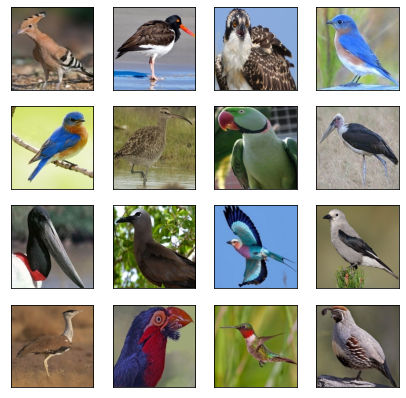

In [39]:
from random import shuffle
sample_files = []
path = './285 birds/valid/'
for r,d,f in os.walk(path):
    for dir in d:
        for r1, d1, f1 in os.walk(os.path.join(path, dir)):
            sample_files.extend([path + dir + '/' + _ for _ in f1])

shuffle(sample_files)

imgs = [mpimg.imread(f) for f in sample_files[:16]]
fig, axs = plt.subplots(4, 4, figsize = (7,7))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(imgs[i])
    ax.set_xticks([])
    ax.set_yticks([])


as you can see the sample images are pretty tightly cropped, therefor I will not crop anymore in preprocessing.
I will, however, rescale to size the images between [0, 1], apply a slight 10 degree rotation and, apply horizontal flips 

In [40]:
batch_size = 128

rotation = 10
target_size = (244, 244)

train_datagen = ImageDataGenerator(
    rescale = 1./255., 
    rotation_range= rotation,
    horizontal_flip=True)

val_datagen = ImageDataGenerator(
    rescale = 1./255.,
    rotation_range = rotation,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(
    rescale = 1./255.)

train_gen = train_datagen.flow_from_directory(
        './285 birds/train',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical')

val_gen = val_datagen.flow_from_directory(
        './285 birds/valid',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical')

test_gen = test_datagen.flow_from_directory(
        './285 birds/test',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical')

Found 40930 images belonging to 285 classes.
Found 1425 images belonging to 285 classes.
Found 1425 images belonging to 285 classes.


Lets get the models ready!

I am using inception net v3, this is a pretrained model that already knows how to idenitfy key features. This particular model was trained on imagenet, a pretty broad daatset so we don't have to worry to much about the filters being overfit. Additionally, this will save my little gtx 1050 a lot of time and effort. 

Inception is a pretty cool idea. In essence: different features have different sizes so it is benifical to run multiple sized filters when convoluting. 

In [44]:

input_shape = (244, 244, 3)

base_model = tf.keras.applications.inception_v3.InceptionV3( include_top=False, weights='imagenet', input_shape = input_shape)

print(base_model.summary())

for layer in base_model.layers:
    layer.trainable = False


Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 244, 244, 3) 0                                            
__________________________________________________________________________________________________
conv2d_282 (Conv2D)             (None, 121, 121, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_282 (BatchN (None, 121, 121, 32) 96          conv2d_282[0][0]                 
__________________________________________________________________________________________________
activation_282 (Activation)     (None, 121, 121, 32) 0           batch_normalization_282[0][0]    
_______________________________________________________________________________________

In [50]:
inputs = Input(shape = input_shape)
x = base_model(inputs)
x = Flatten()(x)
x = Dropout(.4)(x)
x = Dense(1024)(x)
x = Dropout(.4)(x)
x = Dense(512)(x)
x = Dropout(.1)(x)

model = tf.keras.Model(inputs = base_model.inputs, outputs = x)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3, beta_1 = .9),
              loss='categorical_crossentropy',
              metrics=['acc'],
              )
print(model.summary())

In [ ]:

history = model.fit(train_gen,
                    validation_data = val_gen,
                    epochs=20,
                    verbose=1)
#model.save_weights('./birdception_check/epoch20')

Error: Session cannot generate requests